In [199]:
import numpy as np
import pandas as pd
import random

In [200]:
##Instalowanie biblioteki talib

!apt-get install -y build-essential wget
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install

!pip install ta-lib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
wget is already the newest version (1.21.2-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
--2024-05-28 22:57:47--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-05-28 22:57:47--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent,

In [201]:
!pip install yfinance
!pip install pyowm

In [202]:
import talib
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime, timedelta
from pyowm import OWM
import json
import requests
random.seed(42)

In [203]:
def FetchDataFromYahooFinance(name = 'AAPL', start='2017-11-06', end='2023-01-03', auto_adjust = True):
   return yf.download(name, start,end,auto_adjust)

In [294]:
# Input: Dataset pobrany z funkcji FetchDataFromYahooFinance
# Output: Przerobiony Dataset, z podstawowymi danymi historycznymi cen tej spółki.
def PrepareBasicDataFromYahooFinance(price_Dataset, if_dropna = True):

  # Preparing the dataset
  price_Dataset['H-L'] = price_Dataset['High'] - price_Dataset['Low']
  price_Dataset['O-C'] = price_Dataset['Close'] - price_Dataset['Open']
  price_Dataset['3day MA'] = price_Dataset['Close'].shift(1).rolling(window = 3).mean()
  price_Dataset['10day MA'] = price_Dataset['Close'].shift(1).rolling(window = 10).mean()
  price_Dataset['30day MA'] = price_Dataset['Close'].shift(1).rolling(window = 30).mean()
  price_Dataset['Std_dev']= price_Dataset['Close'].rolling(5).std()
  price_Dataset['RSI'] = talib.RSI(price_Dataset['Close'].values, timeperiod = 9)
  price_Dataset['Williams %R'] = talib.WILLR(price_Dataset['High'].values, price_Dataset['Low'].values, price_Dataset['Close'].values, 7)

  # Wybieranie output'u:
  # W tym przypadku dla każdego dnia, czy cena wzrosła czy zmalała.
  price_Dataset['Price_Rise'] = np.where(price_Dataset['Close'].shift(-1) > price_Dataset['Close'], 1, 0)

  # Wyrzucamy reszte nie potrzebnych wierszy.
  if(if_dropna):
    price_Dataset = price_Dataset.dropna()

  return price_Dataset

def merge_lists(*args):
    merged_list = []  # Utwórz pustą listę na połączone listy

    # Dodaj elementy z każdej listy
    for lst in args:
        merged_list.extend(lst)

    return merged_list

def duplicate_elements(my_list):
    duplicated_list = []  # Utwórz pustą listę na wynik

    for item in my_list:
        # Powiel każdy element tyle razy, ile wynosi długość listy
        duplicated_list.extend([item] * 3)

    return duplicated_list

# Input: Podaj przedział czasowy oraz aders stacji z której chcesz korzystać:
#         https://www.ncdc.noaa.gov/cdo-web/datatools/findstation
def GetWeatherData(start_date, end_date, station_id = 'GHCND:USW00013889'):
      #Prywatny token, należy go zmienić dla własnych zastosowań
      token = 'HowCtylSxAtBItdFBRlBPnTMKQwzBSvI'

      # Initialize lists to store data
      dates_temp = []
      dates_prcp = []
      dates = []
      temps = []
      minT = []
      maxT = []
      prcp = []


      # Make the api call to the necessary urls.
      url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG&datatypeid=TMAX&limit=1000'
      url = url + '&stationid=' + station_id
      url = url + '&startdate=' + start_date
      url = url + '&enddate='   + end_date
      r = requests.get(url, headers={'token':token})

      url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMIN&datatypeid=PRCP&limit=1000'
      url = url + '&stationid=' + station_id
      url = url + '&startdate=' + start_date
      url = url + '&enddate='   + end_date
      r2 = requests.get(url, headers={'token':token})

      # Load the api response as a json file.
      d = json.loads(r.text)
      d2 = json.loads(r2.text)

      # Organize the data by type..
      # Average temperature.
      avg_temps = [item for item in d['results'] if item['datatype']=='TAVG']
      # Minimum temperature.
      min_temps = [item for item in d2['results'] if item['datatype']=='TMIN']
      # Maximum temperature.
      max_temps = [item for item in d['results'] if item['datatype']=='TMAX']
      # Precipitation.
      precp = [item for item in d2['results'] if item['datatype']=='PRCP']
      # Dates.
      dates_temp += [item['date'] for item in avg_temps]

      # Get the actual average temperature from all average temperature readings.
      dates += [datetime.strptime(item, "%Y-%m-%dT%H:%M:%S").strftime("%Y-%m-%d") for item in dates_temp]
      temps += [item['value'] for item in avg_temps]
      minT  += [item['value'] for item in min_temps]
      maxT  += [item['value'] for item in max_temps]
      prcp  += [item['value'] for item in precp]

      return dates, temps, minT, maxT, prcp

# Input: Dataset pobrany z funkcji FetchDataFromYahooFinance
# Output: Przerobiony Dataset, z podstawowymi danymi historycznymi cen tej spółki.
def PrepareAdvancedDataFromYahooFinance(name, start_date, end_date, if_dropna = True):

  price_Dataset = FetchDataFromYahooFinance(name, start_date, end_date, True)

  # Preparing the dataset
  price_Dataset['H-L'] = price_Dataset['High'] - price_Dataset['Low']
  price_Dataset['O-C'] = price_Dataset['Close'] - price_Dataset['Open']
  price_Dataset['3day MA'] = price_Dataset['Close'].shift(1).rolling(window = 3).mean()
  price_Dataset['10day MA'] = price_Dataset['Close'].shift(1).rolling(window = 10).mean()
  price_Dataset['30day MA'] = price_Dataset['Close'].shift(1).rolling(window = 30).mean()
  price_Dataset['Std_dev']= price_Dataset['Close'].rolling(5).std()
  price_Dataset['RSI'] = talib.RSI(price_Dataset['Close'].values, timeperiod = 9)
  price_Dataset['Williams %R'] = talib.WILLR(price_Dataset['High'].values, price_Dataset['Low'].values, price_Dataset['Close'].values, 7)
  #price_Dataset['Date']= pd.to_datetime(price_Dataset['Date']).dt.strftime('%Y-%m-%d')

  # Indeksy sp500
  sp500 = web.DataReader('SP500', 'fred', start=start_date, end=end_date)
  #sp500['DATE'] = pd.to_datetime(sp500['DATE']).dt.strftime('%Y-%m-%d')

  print(sp500.head())

  # Pobieranie danych historiczynych danych realnej gospodarki.
  gdp = web.DataReader('GDP', 'fred', start=start_date, end=end_date)
  print(gdp.head())

  # Pobrany ze strony https://home.openweathermap.org/api_keys
  # Wymaganie założenie własnego konta. API_key jest przypisany do danego konta.
  # Bardzo dobra opcja, bardzo wygodna i dużo danych niestety
  # musimy zapłacić jeżeli chcemy pobierać dane historyczne.
  # Memy jednak możliwośc za darmo pobieranie danych w czasie rzeczywistym

  #owm = OWM('3ca2dd90c10b6a15155f1f6ef2d66ac4')
  #mgr = owm.weather_manager()

  # Pobierz dane pogodowe dla wybranych miast w Stanach Zjednoczonych
  cities = ['New York, US', 'Los Angeles, US', 'Chicago, US', 'Houston, US', 'Phoenix, US']

  # Pobierz dane z 3 różnych stacji ze stanów:
  print("Bazowa stacja Jacksonville :")
  dates1, temps1, minT1, maxT1, prcp1 = GetWeatherData(start_date, end_date)

  Los_Angeles_id = "GHCND:USW00093134"
  print("Los Angeles  : GHCND:USW00093134")
  dates2, temps2, minT2, maxT2, prcp2 = GetWeatherData(start_date, end_date, Los_Angeles_id)

  NewYork_id =  "GHCND:USW00094728"
  print("New York : GHCND:USW00094728")
  dates3, temps3, minT3, maxT3, prcp3 = GetWeatherData(start_date, end_date, NewYork_id)

  # Połącz dane i stwórz z nich pandasdataframe.
  #temps = merge_lists(temps1, temps2, temps3)
  #minT = merge_lists(minT1, minT2, minT3)
  #maxT = merge_lists(maxT1, maxT2, maxT3)
  #prcp = merge_lists(prcp1, prcp2, prcp3)
  #dates = merge_lists(dates1, dates2, dates3)

  #print(len(dates1))
  #print(len(temps1))
  #print(len(minT1))
  #print(len(maxT1))
  #print(len(prcp2))
  #print(len(temps2))
  #print(len(minT2))
  #print(len(maxT2))
  #print(len(prcp2))
  #print(len(temps3))
  #print(len(minT3))
  #print(len(maxT3))
  #print(len(prcp3))

  # Tworzenie pandasa dla zebranych danych
  weather_df = pd.DataFrame({
    'Date' : dates1,
    'Temperature Jacksonville': temps1,
    'Min Temperature Jacksonville': minT1,
    'Max Temperature Jacksonville': maxT1,
    'Precipitation Jacksonville': prcp1,
    #'Temperature Los Angeles': temps1,
    'Min Temperature Los Angeles': minT2,
    'Max Temperature Los Angeles': maxT2,
    'Precipitation Los Angeles': prcp2,
    #'Temperature New York': temps3,
    'Min Temperature New York': minT3,
    'Max Temperature New York': maxT3,
    'Precipitation New York': prcp3,
  })

  print("Pogoda:")
  print(weather_df.head())

  # Wybieranie output'u:
  # W tym przypadku dla każdego dnia, czy cena wzrosła czy zmalała.
  price_Dataset['Price_Rise'] = np.where(price_Dataset['Close'].shift(-1) > price_Dataset['Close'], 1, 0)

  # Wyrzucamy reszte nie potrzebnych wierszy.
  if(if_dropna):
    price_Dataset = price_Dataset.dropna()

  df_list = [price_Dataset, weather_df, sp500]

  return  price_Dataset, weather_df, sp500, gdp


In [295]:
name = 'AAPL'
start='2018-01-01'
end='2019-01-01'

price_AAPL = FetchDataFromYahooFinance(name,start,end)
price_AAPL = PrepareBasicDataFromYahooFinance(price_AAPL)

price_Dataset, weather_df, sp500, gdp = PrepareAdvancedDataFromYahooFinance(name, start, end, True)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


              SP500
DATE               
2018-01-01      NaN
2018-01-02  2695.81
2018-01-03  2713.06
2018-01-04  2723.99
2018-01-05  2743.15
                  GDP
DATE                 
2018-01-01  20328.553
2018-04-01  20580.912
2018-07-01  20798.730
2018-10-01  20917.867
2019-01-01  21104.133
Bazowa stacja Jacksonville :
Los Angeles  : GHCND:USW00093134
New York : GHCND:USW00094728
Pogoda:
         Date  Temperature Jacksonville  Min Temperature Jacksonville  \
0  2018-01-01                        56                            22   
1  2018-01-02                        19                            -5   
2  2018-01-03                        21                           -10   
3  2018-01-04                        20                           -21   
4  2018-01-05                        25                           -21   

   Max Temperature Jacksonville  Precipitation Jacksonville  \
0                            83                          41   
1                            50           

In [296]:
# Łączenie DataFrame w jeden na podstawie kolumny 'Date'
weather_df.set_index('Date', inplace=True)
weather_df.index = pd.to_datetime(weather_df.index)

price_Dataset = price_Dataset.rename_axis('Date')
weather_df = weather_df.rename_axis('Date')
sp500 = sp500.rename_axis('Date')

merged_df = pd.concat([price_Dataset, weather_df, sp500], axis=1, join='outer')

In [297]:
price_AAPL_ADVANCED = merged_df.dropna()

# Przygytowanie danych do trenowania
X = price_AAPL.iloc[:, 4:-1]
y = price_AAPL.iloc[:, -1]

# Przygytowanie danych do trenowania
X_ADVANCED = price_AAPL_ADVANCED.drop(columns=['Price_Rise'])  #.iloc[:, 4:-1]
y_ADVANCED = price_AAPL_ADVANCED['Price_Rise']  #.iloc[:, -1]

In [208]:
print("Price ds")
print(len(price_Dataset))
print(price_Dataset.index.dtype)
print(price_Dataset.head)

print("Weather")
print(weather_df.index.dtype)
print(len(weather_df))
print(weather_df.head)

print("sp500")
print(sp500.index.dtype)
print(len(sp500))
print(sp500.head)

print("gdp")
print(gdp.index.dtype)
print(len(gdp))
print(gdp)

Price ds
221
datetime64[ns]
<bound method NDFrame.head of                  Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2018-02-14  40.759998  41.884998  40.720001  41.842499  39.623806  162579600   
2018-02-15  42.447498  43.272499  42.250000  43.247501  40.954308  204588800   
2018-02-16  43.090000  43.705002  42.942501  43.107498  40.821724  160704400   
2018-02-20  43.012501  43.564999  42.855000  42.962502  40.684422  135722000   
2018-02-21  43.207500  43.529999  42.752499  42.767502  40.499767  149886400   
...               ...        ...        ...        ...        ...        ...   
2018-12-24  37.037498  37.887501  36.647499  36.707500  35.139698  148676800   
2018-12-26  37.075001  39.307499  36.680000  39.292500  37.614285  234330000   
2018-12-27  38.959999  39.192501  37.517502  39.037498  37.370178  212468400   
2018-12-28  39.375000  39.630001  38.637501  39.057499  37.389

In [298]:
split = int(len(price_AAPL)*0.80)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]


split_ADVANCED = int(len(price_AAPL_ADVANCED)*0.80)
X_train_ADVANCED, X_test_ADVANCED, y_train_ADVANCED, y_test_ADVANCED = X_ADVANCED[:split_ADVANCED], X_ADVANCED[split_ADVANCED:], y_ADVANCED[:split_ADVANCED], y_ADVANCED[split_ADVANCED:]

In [299]:
# Feature Scaling
# Skalowanie do wartości z przedziału 0 do 1.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train_ADVANCED = sc.fit_transform(X_train_ADVANCED)
X_test_ADVANCED = sc.transform(X_test_ADVANCED)

In [300]:
# Importowanie bibilotek do tworzenia sieci
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [301]:
classifier = Sequential()

classifier_ADVANCED = Sequential()

In [302]:
# Dodawanie warstw
classifier.add(Dense(units = 128, kernel_initializer = 'uniform'
, activation = 'relu', input_dim = X.shape[1]))

classifier.add(Dense(units = 128, kernel_initializer = 'uniform'
, activation = 'relu'))

classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [303]:
# Dodawanie warstw dla modelu Zaawansowanego
classifier_ADVANCED.add(Dense(units = 128, kernel_initializer = 'uniform'
, activation = 'relu', input_dim = X_ADVANCED.shape[1]))

classifier_ADVANCED.add(Dense(units = 128, kernel_initializer = 'uniform'
, activation = 'relu'))

classifier_ADVANCED.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

classifier_ADVANCED.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [304]:
# Trenowanie
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
18/18 [==============================] - 1s 3ms/step - loss: 0.2503 - accuracy: 0.4943
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2490 - accuracy: 0.5455
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2482 - accuracy: 0.5455
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2462 - accuracy: 0.5455
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2459 - accuracy: 0.5455
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2422 - accuracy: 0.5511
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2408 - accuracy: 0.5341
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2379 - accuracy: 0.5739
Epoch 9/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.5682
Epoch 10/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2319 - accuracy: 0.6250
Epoch 11/

In [305]:
# Trenowanie dla modelu zaawansowanego
classifier_ADVANCED.fit(X_train_ADVANCED, y_train_ADVANCED, batch_size = 10, epochs = 100)

Epoch 1/100
18/18 [==============================] - 1s 2ms/step - loss: 0.2504 - accuracy: 0.4659
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2473 - accuracy: 0.5682
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2445 - accuracy: 0.6080
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2381 - accuracy: 0.5909
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2296 - accuracy: 0.6591
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2201 - accuracy: 0.6648
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2127 - accuracy: 0.6705
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2075 - accuracy: 0.7045
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 0.1972 - accuracy: 0.6875
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 0.1938 - accuracy: 0.6989
Epoch 11/

In [306]:
# Wybieranie wyniku z przewidywań:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

y_pred_ADVANCED = classifier_ADVANCED.predict(X_test_ADVANCED)
y_pred_ADVANCED = (y_pred_ADVANCED > 0.5)

2/2 [==============================] - 0s 5ms/step


In [307]:
def CumulativeTradePrice(y_pred, price_AAPL):

  price_AAPL['y_pred'] = np.NaN
  price_AAPL.iloc[(len(price_AAPL) - len(y_pred)):,-1:] = y_pred
  trade_price_AAPL = price_AAPL.dropna()

  trade_price_AAPL['Tomorrows Returns'] = 0.
  trade_price_AAPL['Tomorrows Returns'] = np.log(trade_price_AAPL['Close']/trade_price_AAPL['Close'].shift(1))
  trade_price_AAPL['Tomorrows Returns'] = trade_price_AAPL['Tomorrows Returns'].shift(-1)

  trade_price_AAPL['Strategy Returns'] = 0.
  trade_price_AAPL['Strategy Returns'] = np.where(trade_price_AAPL['y_pred'] == True,
  trade_price_AAPL['Tomorrows Returns'], - trade_price_AAPL['Tomorrows Returns'])

  trade_price_AAPL['Cumulative Market Returns'] = np.cumsum(trade_price_AAPL['Tomorrows Returns'])
  trade_price_AAPL['Cumulative Strategy Returns'] = np.cumsum(trade_price_AAPL['Strategy Returns'])

  return trade_price_AAPL


trade_price_AAPL = CumulativeTradePrice(y_pred, price_AAPL)
trade_price_AAPL_ADVANCED = CumulativeTradePrice(y_pred_ADVANCED, price_AAPL_ADVANCED)

<ipython-input-307-983cb6251ca1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_price_AAPL['Tomorrows Returns'] = 0.
<ipython-input-307-983cb6251ca1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_price_AAPL['Tomorrows Returns'] = np.log(trade_price_AAPL['Close']/trade_price_AAPL['Close'].shift(1))
<ipython-input-307-983cb6251ca1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [308]:
# Wyświetlanie wykresów:
import matplotlib.pyplot as plt
def ShowPlotOfMarketVsOurModel(trade_price_AAPL):

  plt.figure(figsize=(10,5))
  plt.plot(trade_price_AAPL['Cumulative Market Returns'], color='r', label='Market Returns')
  plt.plot(trade_price_AAPL['Cumulative Strategy Returns'], color='g', label='Strategy Returns')

  plt.title('Market returns and Strategy returns', color='purple', size=15)

  # Setting axes labels for close prices plot
  plt.xlabel('Dates', {'color': 'orange', 'fontsize':15})
  plt.ylabel('Returns(%)', {'color': 'orange', 'fontsize':15})

  plt.legend()
  plt.show()


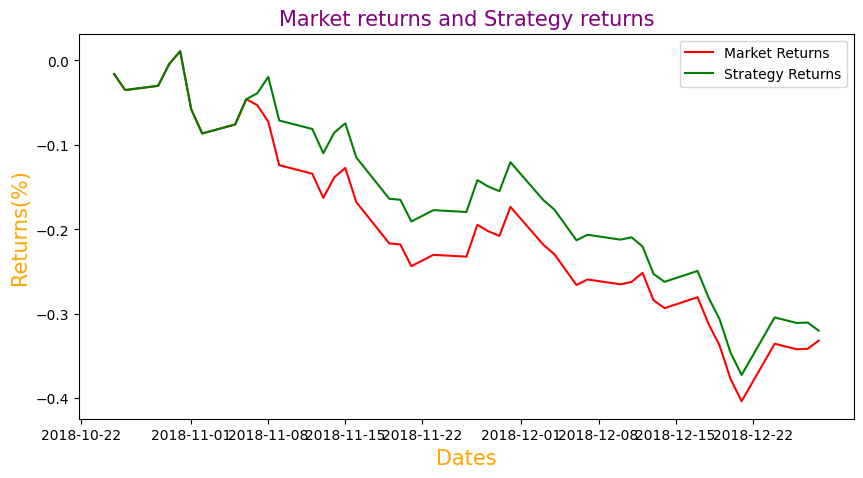

In [309]:
ShowPlotOfMarketVsOurModel(trade_price_AAPL)

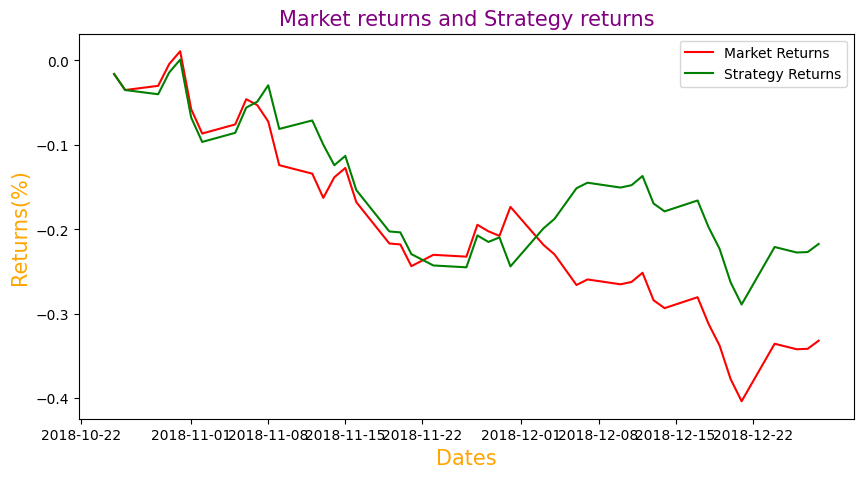

In [310]:
ShowPlotOfMarketVsOurModel(trade_price_AAPL_ADVANCED)